In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

In [2]:
df = pd.read_csv('air_dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    9357 non-null   int64  
 1   CO(GT)        9357 non-null   float64
 2   C6H6(GT)      9357 non-null   float64
 3   NOx(GT)       9357 non-null   float64
 4   PT08.S3(NOx)  9357 non-null   float64
 5   NO2(GT)       9357 non-null   float64
 6   T             9357 non-null   float64
 7   RH            9357 non-null   float64
 8   weekend       9357 non-null   int64  
 9   PT08_feat     9357 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 731.1 KB


In [4]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

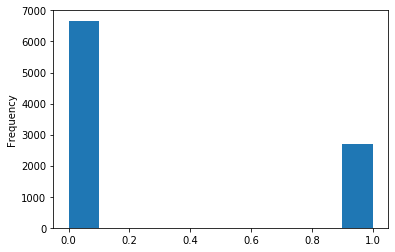

In [5]:
df['weekend'].plot(kind = 'hist')

## DATA PARTITIONING

In [6]:
class_name = 'weekend'
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [7]:
X_train.shape

(6549, 8)

In [8]:
df.describe()

,CO(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),T,RH,weekend,PT08_feat
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-4.387203,9.761680,168.605536,833.786263,103.434438,17.982294,48.851309,0.287272,1127.383115
std,14.027700,7.474419,257.427995,251.865233,48.631623,8.814727,17.079489,0.452514,274.459534
min,-34.207524,0.100000,-200.000000,322.000000,2.000000,-1.900000,9.200000,0.000000,469.500000
25%,0.600000,4.000000,50.000000,666.000000,58.135834,10.900000,36.600000,0.000000,930.750000
50%,1.500000,7.900000,141.000000,794.871754,96.000000,17.200000,48.600000,0.000000,1079.000000
75%,2.600000,13.600000,284.000000,960.000000,133.000000,24.100000,61.900000,1.000000,1290.000000
max,11.900000,63.700000,1479.000000,2683.000000,340.000000,44.600000,88.700000,1.000000,2265.500000


## VARIANCE THRESHOLD

In [9]:
#se non ho capito male questo metodo elimina gli attributi che hanno la deviazione standard al di sotto di una determinata  
#soglia che gli passo io

In [10]:
#faccio un primo tentativo tenendo solo le 3 colonne che hanno una varianza pazzesca

In [11]:
sel = VarianceThreshold(threshold=(2500.0))
X_train_sel = sel.fit_transform(X_train)

X_train_sel.shape

(6549, 3)

In [12]:
# la prima colonna è NOx(GT), la seconda è PT08.S3(NOx),la terza è PT08_feat

In [13]:
'''for i in df:
    print(i, df[str(i)].min(), df[str(i)].max())
prima_colonna = []
for i in X_train_sel:
    prima_colonna.append(i[2])
x = 0
b = 10000
for i in prima_colonna:
    if i > x:
        x = i
    if i < b:
        b = i
print(x, b)'''

'for i in df:\n    print(i, df[str(i)].min(), df[str(i)].max())\nprima_colonna = []\nfor i in X_train_sel:\n    prima_colonna.append(i[2])\nx = 0\nb = 10000\nfor i in prima_colonna:\n    if i > x:\n        x = i\n    if i < b:\n        b = i\nprint(x, b)'

In [14]:
for i in df:
    print(i, df[str(i)].min(), df[str(i)].max())

CO(GT) -34.20752377898906 11.9
C6H6(GT) 0.1 63.7
NOx(GT) -200.0 1479.0
PT08.S3(NOx) 322.0 2683.0
NO2(GT) 2.0 340.0
T -1.9 44.6
RH 9.2 88.7
weekend 0 1
PT08_feat 469.5 2265.5


In [15]:
X_test_sel = sel.transform(X_test)

# STANDARDIZZO
scaler = StandardScaler()
scaler.fit(X_train_sel)
X_train_sel = scaler.transform(X_train_sel)

In [16]:
## ORA APPLICO GRIDSEARCH PER L'APPLICAZIONE DI UN ALGORITMO DI CLASSIFICATION PASSANDOGLI COMUNQUE I BEST PARAMETERSù

### GRIDSEARCH

In [17]:
decisiontree = DecisionTreeClassifier()
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10,12]
min_sample_leaf = [1,2,3]
parameters = dict(decisiontree__criterion=criterion,
                      decisiontree__max_depth=max_depth)

params = {'criterion' : ['gini', 'entropy'],'max_depth': max_depth}
grid_dt = GridSearchCV(estimator = decisiontree,
                        param_grid = params,
                        scoring = 'accuracy',
                        cv = 5, 
                        verbose = 1,
                        n_jobs = -1)

In [18]:
grid_dt.fit(X_train_sel, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                     

In [19]:
grid_dt.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

## APPLICAZIONE DECISION TREE

In [20]:
clf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

# QUI C'E UN PROBLEMA PER CUI MAGARI NE PARLIAMO ASSIEME 

In [21]:
clf.fit(X_train_sel, y_train)

y_pred = clf.predict(X_test_sel)

print('CON PARAMETRO ZERO DIVISION = 1')
print("\n")
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, zero_division = 1))

CON PARAMETRO ZERO DIVISION = 1


Accuracy 0.28739316239316237
F1-score [0.         0.44647303]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      2001
           1       0.29      1.00      0.45       807

    accuracy                           0.29      2808
   macro avg       0.64      0.50      0.22      2808
weighted avg       0.80      0.29      0.13      2808



In [22]:
print('CON PARAMETRO ZERO DIVISION = 0')
print("\n")
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, zero_division = 1))

CON PARAMETRO ZERO DIVISION = 0


Accuracy 0.28739316239316237
F1-score [0.         0.44647303]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      2001
           1       0.29      1.00      0.45       807

    accuracy                           0.29      2808
   macro avg       0.64      0.50      0.22      2808
weighted avg       0.80      0.29      0.13      2808



In [23]:
# roc curve

In [24]:
y_score = clf.predict_proba(X_test_sel)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

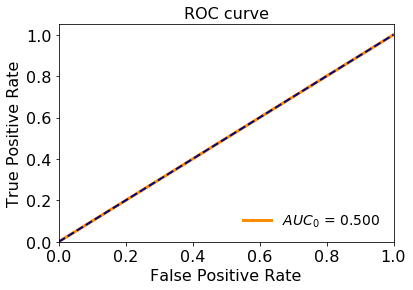

In [25]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [26]:
#lift chart

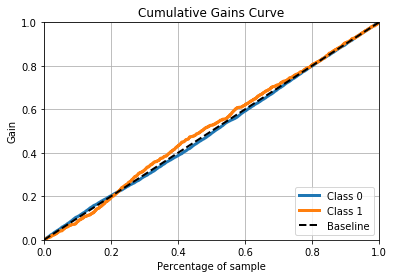

In [27]:
plot_cumulative_gain(y_test, y_score)
plt.show()

## UNIVARIATE FEATURE SELECTION

In [28]:
sel = SelectKBest(k=4)
X_train_sel = sel.fit_transform(X_train, y_train)

X_train_sel.shape

(6549, 4)

In [29]:
#GRIDSEARCH

In [30]:
grid_dt = GridSearchCV(estimator = decisiontree,
                        param_grid = params,
                        scoring = 'accuracy',
                        cv = 5, 
                        verbose = 1,
                        n_jobs = -1)

In [31]:
grid_dt.fit(X_train_sel, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                     

In [32]:
best_dt = grid_dt.best_estimator_

In [33]:
X_test_sel = sel.transform(X_test)

best_dt.fit(X_train_sel, y_train)

y_pred = best_dt.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, zero_division = 1))

Accuracy 0.7097578347578347
F1-score [0.82416397 0.16921509]
              precision    recall  f1-score   support

           0       0.73      0.95      0.82      2001
           1       0.48      0.10      0.17       807

    accuracy                           0.71      2808
   macro avg       0.60      0.53      0.50      2808
weighted avg       0.65      0.71      0.64      2808



In [34]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, zero_division = 0))

Accuracy 0.7097578347578347
F1-score [0.82416397 0.16921509]
              precision    recall  f1-score   support

           0       0.73      0.95      0.82      2001
           1       0.48      0.10      0.17       807

    accuracy                           0.71      2808
   macro avg       0.60      0.53      0.50      2808
weighted avg       0.65      0.71      0.64      2808



In [35]:
##AGGIUNGENDO UNA QUARTA VARIABILE IL RISULTATO MIGLIORA DIBRUTTO. provo a capire di che variabile di tratta. 

In [36]:
for i in df:
    print(i, df[str(i)].min(), df[str(i)].max())
prima_colonna = []
for i in X_train_sel:
    prima_colonna.append(i[3])
x = 0
b = 10000
for i in prima_colonna:
    if i > x:
        x = i
    if i < b:
        b = i
print(x, b)

CO(GT) -34.20752377898906 11.9
C6H6(GT) 0.1 63.7
NOx(GT) -200.0 1479.0
PT08.S3(NOx) 322.0 2683.0
NO2(GT) 2.0 340.0
T -1.9 44.6
RH 9.2 88.7
weekend 0 1
PT08_feat 469.5 2265.5
2265.5 471.75


In [37]:
#PROBABILMENTE LA VARIABILE CHE SI AGGIUNGE è PT08_feat

In [38]:
#roc curve

In [39]:
y_score = best_dt.predict_proba(X_test_sel)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

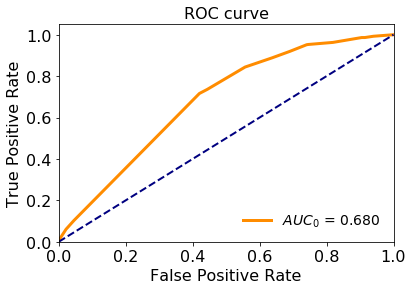

In [40]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [41]:
#lift chart

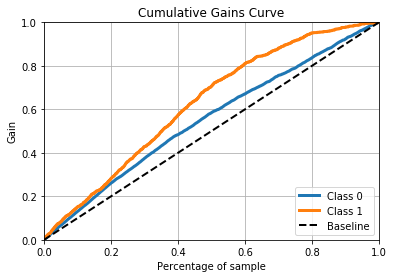

In [42]:
plot_cumulative_gain(y_test, y_score)
plt.show()

## RECURSIVE FEATURES ELIMINATION

In [43]:
# RICARICO IL DATASET E RIFACCIO LA PARTIZIONE PERCHE' TESTANDO SU UN NOTEBOOK A PARTE
#I RISULTATI CAMBIANO PROBABILMENTE PERCHE' IL DECISION TREE E' GIA' FITTATO

In [44]:
df = pd.read_csv('air_dataset.csv')

In [45]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [46]:
class_name = 'weekend'
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [47]:
sel = SelectFromModel(DecisionTreeClassifier(), threshold = 0.123)
X_train_sel = sel.fit_transform(X_train, y_train)
X_train_sel.shape

(6549, 4)

In [48]:
X_test_sel = sel.transform(X_test)
clf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
clf.fit(X_train_sel, y_train)

y_pred = clf.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7108262108262108
F1-score [0.82409012 0.188     ]
              precision    recall  f1-score   support

           0       0.73      0.95      0.82      2001
           1       0.49      0.12      0.19       807

    accuracy                           0.71      2808
   macro avg       0.61      0.53      0.51      2808
weighted avg       0.66      0.71      0.64      2808



In [49]:
# tenendo 4 attributi piuttosto di 7, la'ccuracy diminuisce di 0.015
#C6H6(GT), PT08.S3(NOx), T, PT08_feat. queste sono i 4 attributi coinvolti

In [50]:
'''for i in df:
    print(i, df[str(i)].min(), df[str(i)].max())
prima_colonna = []
for i in X_train_sel:
    prima_colonna.append(i[3])
x = 0
b = 10000
for i in prima_colonna:
    if i > x:
        x = i
    if i < b:
        b = i
print(b, x)'''

'for i in df:\n    print(i, df[str(i)].min(), df[str(i)].max())\nprima_colonna = []\nfor i in X_train_sel:\n    prima_colonna.append(i[3])\nx = 0\nb = 10000\nfor i in prima_colonna:\n    if i > x:\n        x = i\n    if i < b:\n        b = i\nprint(b, x)'

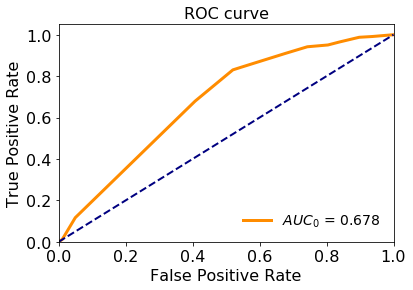

In [51]:
y_score = clf.predict_proba(X_test_sel)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

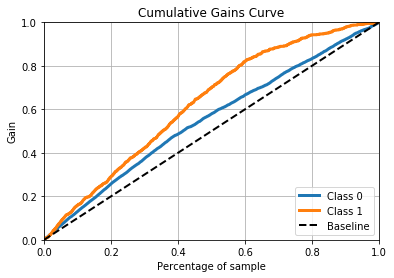

In [52]:
plot_cumulative_gain(y_test, y_score)
plt.show()

## PCA

In [53]:
pca = PCA(n_components=5)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

In [54]:
X_train_pca.shape

(6549, 5)

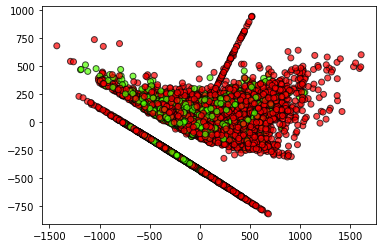

In [55]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

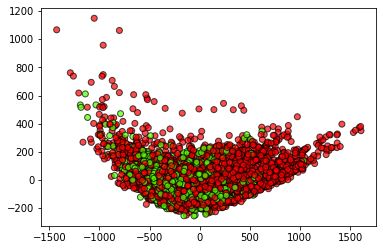

In [56]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 2], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

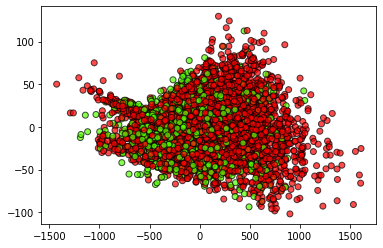

In [57]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 3], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

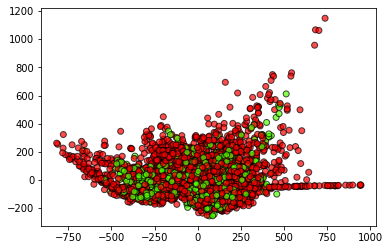

In [58]:
plt.scatter(X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

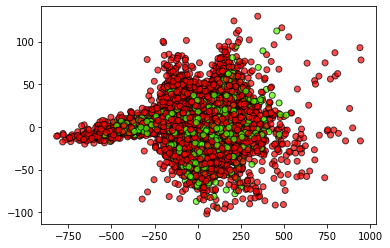

In [59]:
plt.scatter(X_train_pca[:, 1], X_train_pca[:, 3], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

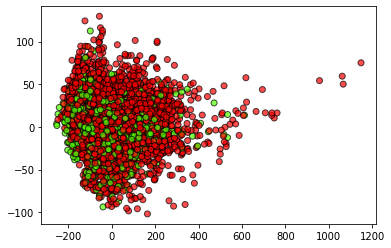

In [60]:
plt.scatter(X_train_pca[:, 2], X_train_pca[:, 3], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

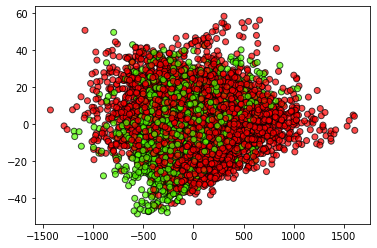

In [61]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 4], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

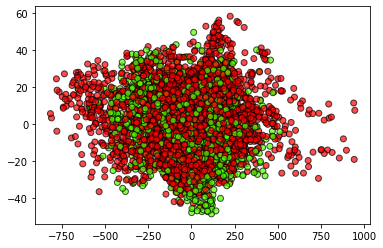

In [62]:
plt.scatter(X_train_pca[:, 1], X_train_pca[:, 4], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

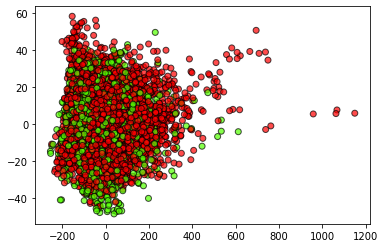

In [63]:
plt.scatter(X_train_pca[:, 2], X_train_pca[:, 4], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

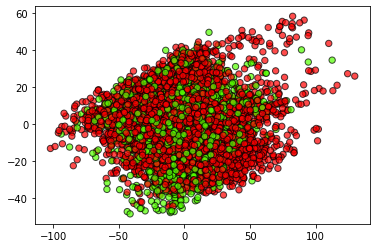

In [64]:
plt.scatter(X_train_pca[:, 3], X_train_pca[:, 4], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7, s = 40)
plt.show()

In [65]:
X_test_pca = pca.transform(X_test)

clf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, ))

Accuracy 0.7175925925925926
F1-score [0.8340657 0.0525687]
              precision    recall  f1-score   support

           0       0.72      1.00      0.83      2001
           1       0.73      0.03      0.05       807

    accuracy                           0.72      2808
   macro avg       0.73      0.51      0.44      2808
weighted avg       0.72      0.72      0.61      2808



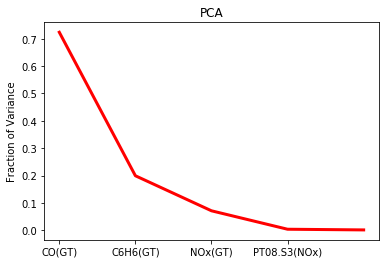

In [66]:
plt.plot(PCA(n_components=5).fit(X_train).explained_variance_ratio_, lw=3, color='r', ms=2)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.xticks(range(4), df.columns)
plt.show()

# IMBALANCED

In [67]:
df.weekend.value_counts()

0    6669
1    2688
Name: weekend, dtype: int64

In [68]:
rows2remove = np.random.choice(df[df[class_name] == 1].index, 2422, replace=False)

In [69]:
len(df), len(rows2remove)

(9357, 2422)

In [70]:
df2 = df.drop(index=rows2remove, axis=0)
print(len(df2))

6935


In [71]:
df2.weekend.value_counts()

0    6669
1     266
Name: weekend, dtype: int64

In [72]:
print('Dataset shape %s' % Counter(df2[class_name]))

Dataset shape Counter({0: 6669, 1: 266})


In [73]:
attributes = [col for col in df.columns if col != class_name]
X = df2[attributes].values
y = df2[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [74]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1], dtype=int64), array([4668,  186], dtype=int64)),
 (array([0, 1], dtype=int64), array([2001,   80], dtype=int64)))

In [75]:
#GRIDSEARCH

In [76]:
decisiontree = DecisionTreeClassifier()
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10,12]
min_sample_leaf = [1,2,3]
parameters = dict(decisiontree__criterion=criterion,
                      decisiontree__max_depth=max_depth)

params = {'criterion' : ['gini', 'entropy'],'max_depth': max_depth}
grid_dt_imbalanced = GridSearchCV(estimator = decisiontree,
                        param_grid = params,
                        scoring = 'accuracy',
                        cv = 5, 
                        verbose = 1,
                        n_jobs = -1)
grid_dt_imbalanced.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                     

In [77]:
best_imb_dt = grid_dt_imbalanced.best_estimator_

In [78]:
best_imb_dt.fit(X_train, y_train)

y_pred = best_imb_dt.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, zero_division = 1))

Accuracy 0.9610764055742431
F1-score [0.98015192 0.        ]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2001
           1       0.00      0.00      0.00        80

    accuracy                           0.96      2081
   macro avg       0.48      0.50      0.49      2081
weighted avg       0.92      0.96      0.94      2081



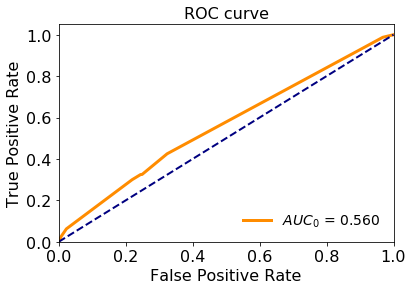

In [79]:
y_score = best_imb_dt.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

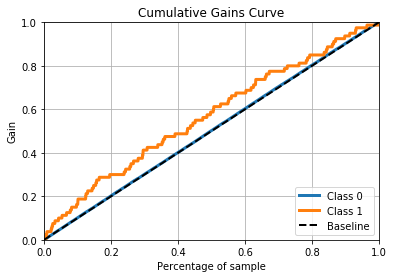

In [80]:
plot_cumulative_gain(y_test, y_score)
plt.show()

## ADJUST THE DECISION THRESHOLD

In [81]:
# NON HO LA PIU' PALLIDA IDEA DI COSA SIA QUESTO CODICE... MAGARI SAREBBE UNA COSA DA CHIEDERE A GUIDOTTI... 
#CIOE'.. A CHE SERVE?

Accuracy 0.925036040365209
F1-score [0.96080402 0.14285714]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2001
           1       0.13      0.16      0.14        80

    accuracy                           0.93      2081
   macro avg       0.55      0.56      0.55      2081
weighted avg       0.93      0.93      0.93      2081



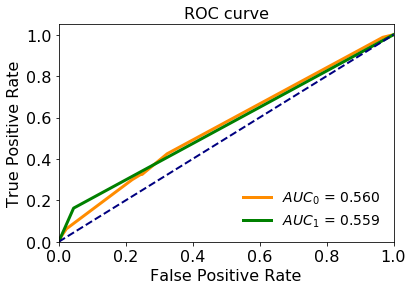

In [82]:
clf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best')
clf.fit(X_train, y_train)

def adjusted_predict(X, thr=0.5):
    y_score = clf.predict_proba(X_test)[:, 1]
    return np.array([1 if y > thr else 0 for y in y_score])

y_pred = adjusted_predict(X_test, thr=0.8)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, thr = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# PCA

In [83]:
X_train.shape

(4854, 8)

In [84]:
pca = PCA(n_components=4)
pca.fit(X_train)
X_pca = pca.transform(X_train)

In [85]:
X_pca.shape


(4854, 4)

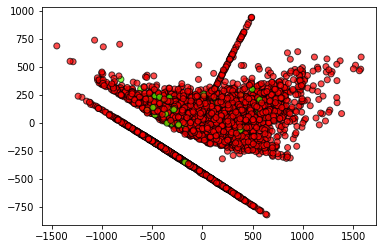

In [86]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

# UNDERSAMPLING

In [87]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour

Using TensorFlow backend.


### RandomUnderSampling

In [88]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 186, 1: 186})


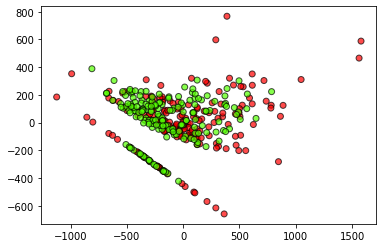

In [89]:
pca = PCA(n_components=3)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [90]:
y_res.shape

(372,)

In [91]:
decisiontree = DecisionTreeClassifier()
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10,12]
min_sample_leaf = [1,2,3]
parameters = dict(decisiontree__criterion=criterion,
                      decisiontree__max_depth=max_depth)

params = {'criterion' : ['gini', 'entropy'],'max_depth': max_depth}
grid = GridSearchCV(estimator = decisiontree,
                        param_grid = params,
                        scoring = 'accuracy',
                        cv = 5, 
                        verbose = 1,
                        n_jobs = -1)
grid = grid.fit(X_pca, y_res)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished


In [92]:
grid.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Accuracy 0.6367131186929361
F1-score [0.77146312 0.1147541 ]
              precision    recall  f1-score   support

           0       0.98      0.64      0.77      2001
           1       0.06      0.61      0.11        80

    accuracy                           0.64      2081
   macro avg       0.52      0.63      0.44      2081
weighted avg       0.94      0.64      0.75      2081



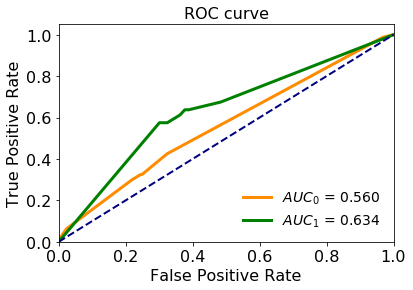

In [93]:
clf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=12, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

### CondensedNearestNeighbour

In [94]:
import warnings
warnings.simplefilter("ignore")

In [95]:
cnn = CondensedNearestNeighbour(random_state=42, n_jobs=10)
X_res, y_res = cnn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

KeyboardInterrupt: 

In [ ]:
decisiontree = DecisionTreeClassifier()
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10,12]
min_sample_leaf = [1,2,3]
parameters = dict(decisiontree__criterion=criterion,
                      decisiontree__max_depth=max_depth)

params = {'criterion' : ['gini', 'entropy'],'max_depth': max_depth}
grid = GridSearchCV(estimator = decisiontree,
                        param_grid = params,
                        scoring = 'accuracy',
                        cv = 5, 
                        verbose = 1,
                        n_jobs = -1)
grid_cnn = grid.fit(X_res, y_res)

In [ ]:
pca = PCA(n_components=3)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [ ]:
grid_cnn.best_estimator_

In [ ]:
clf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()


In [ ]:
plot_cumulative_gain(y_test, y_score)
plt.show()

# CLASS WEIGHT

Accuracy 0.9572320999519461
F1-score [0.97813805 0.02197802]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2001
           1       0.09      0.01      0.02        80

    accuracy                           0.96      2081
   macro avg       0.53      0.50      0.50      2081
weighted avg       0.93      0.96      0.94      2081



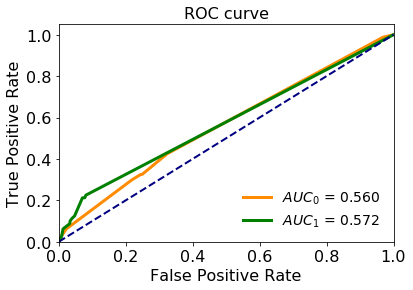

In [96]:
clf = DecisionTreeClassifier(min_samples_leaf=3, class_weight={0:5, 1: 0.5}, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

## Meta-Cost Sensitive Classifier

In [97]:
from costcla.models import CostSensitiveDecisionTreeClassifier
from costcla.metrics import savings_score

In [98]:
cost = [1, 10, 0, 0]
cost_mat = np.array([cost] * len(X_train))
cost_mat.shape

(4854, 4)

In [99]:
cost_mat

array([[ 1, 10,  0,  0],
       [ 1, 10,  0,  0],
       [ 1, 10,  0,  0],
       ...,
       [ 1, 10,  0,  0],
       [ 1, 10,  0,  0],
       [ 1, 10,  0,  0]])

Accuracy 0.9615569437770303
F1-score [0.98040176 0.        ]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2001
           1       0.00      0.00      0.00        80

    accuracy                           0.96      2081
   macro avg       0.48      0.50      0.49      2081
weighted avg       0.92      0.96      0.94      2081



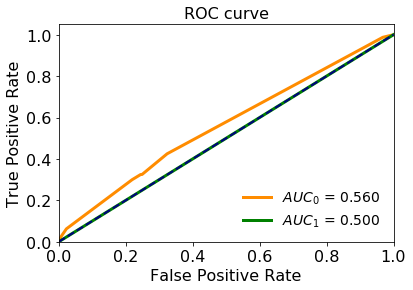

In [100]:
clf = CostSensitiveDecisionTreeClassifier()
clf.fit(X_train, y_train, cost_mat)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [101]:
cost_mat_test = np.array([cost] * len(X_test))
print(savings_score(y_test, y_pred, cost_mat_test))

0.0


# SCIKITPLOT

In [102]:
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

In [103]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)
decisiontree = DecisionTreeClassifier()
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10,12]
min_sample_leaf = [1,2,3]
parameters = dict(decisiontree__criterion=criterion,
                      decisiontree__max_depth=max_depth)

params = {'criterion' : ['gini', 'entropy'],'max_depth': max_depth}
grid = GridSearchCV(estimator = decisiontree,
                        param_grid = params,
                        scoring = 'accuracy',
                        cv = 5, 
                        verbose = 1,
                        n_jobs = -1)
grid_search = grid.fit(X_train, y_train)
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

y_pred = best_clf.predict(X_test)
y_score = best_clf.predict_proba(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    2.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished


Accuracy 0.7161680911680912
F1-score [0.82101954 0.31470335]
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      2001
           1       0.51      0.23      0.31       807

    accuracy                           0.72      2808
   macro avg       0.63      0.57      0.57      2808
weighted avg       0.68      0.72      0.68      2808



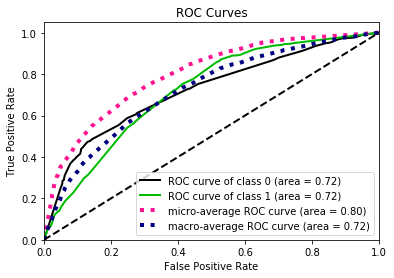

In [104]:
plot_roc(y_test, y_score)
plt.show()

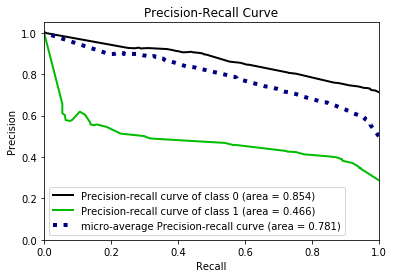

In [105]:
plot_precision_recall(y_test, y_score)
plt.show()

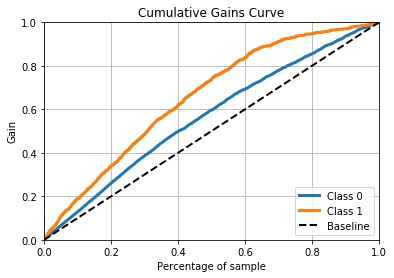

In [106]:
plot_cumulative_gain(y_test, y_score)
plt.show()

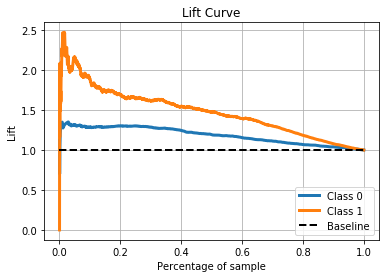

In [107]:
plot_lift_curve(y_test, y_score)
plt.show()